# Baseline Model



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_format='%Y-%m'):
        self.date_format = date_format
        
    def diff_month(self, d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
        
    def transform(self, X, y=None, **fit_params):
        print('\nPerforming date transforming...')
        dates = X.apply(lambda x: datetime.strptime(x, self.date_format))
        return pd.DataFrame(dates.apply(lambda x: self.diff_month(self.max_date, x)))
    
    def fit(self, X, y=None, **fit_params):
        dates = X.apply(lambda x: datetime.strptime(x, self.date_format))
        self.max_date = dates.max()
        return self
    
class DummyEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, categories='auto', sparse=True):
        self.categories = categories
        self.sparse = sparse

    def transform(self, X, y=None, **fit_params):
        print('\nEncoding dummy variables...')
        return self.ohe.transform(X)

    def fit(self, X, y=None, **fit_params):
        self.ohe = OneHotEncoder(sparse=self.sparse, categories=self.categories)
        self.ohe.fit(X)
        return self
    
class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols_to_drop):
        assert isinstance(cols_to_drop, list)
        self.cols_to_drop = cols_to_drop
    
    def transform(self, X, y=None, **fit_params):
        print('\nDropping columns...')
        return np.delete(X, self.cols_to_drop, axis=1)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
#Read in raw data
data = pd.read_csv('data/train.csv').set_index('card_id')
print('Original data:')
print(data.head())

#Split data X, y
X = data.drop('target', axis=1)
y = data['target']

#Define processing pipeline
preprocessing = Pipeline([('ColumnTransformer', ColumnTransformer([('DateTransformer', DateTransformer(), 'first_active_month'),
                                                                   ('OneHotEncoder', DummyEncoder(categories='auto', sparse=False), ['feature_1', 'feature_2']),
                                                                   ('OrdinalEncoder', OrdinalEncoder(categories='auto'), ['feature_3'])], 
                                                                  remainder='passthrough')),
                          ('DropTransformer', DropTransformer(cols_to_drop=[1,6])),
                          ('Scaler', ColumnTransformer([('Scaler', StandardScaler(with_mean=True, with_std=True), [0])],
                                                      remainder='passthrough'))])

#Transform data using pipeline above
X = preprocessing.fit_transform(X)

print('\nTransformed data:')
print(X[:5])
print('\nTargets:')
print(y[:5])

Original data:
                first_active_month  feature_1  feature_2  feature_3    target
card_id                                                                      
C_ID_92a2005557            2017-06          5          2          1 -0.820283
C_ID_3d0044924f            2017-01          4          1          0  0.392913
C_ID_d639edf6cd            2016-08          2          2          0  0.688056
C_ID_186d6a6901            2017-09          4          3          0  0.142495
C_ID_cdbd2c0db2            2017-11          1          3          0 -0.159749

Performing date transforming...

Encoding dummy variables...

Dropping columns...

Transformed data:
[[-0.46748063  0.          0.          0.          1.          1.
   0.          1.        ]
 [ 0.05082796  0.          0.          1.          0.          0.
   0.          0.        ]
 [ 0.56913655  1.          0.          0.          0.          1.
   0.          0.        ]
 [-0.77846579  0.          0.          1.          0.     

In [4]:
from sklearn.metrics import make_scorer, mean_squared_error
def rmse(y, y_pred, **kwargs):
    return np.sqrt(mean_squared_error(y, y_pred))

rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)

In [5]:
#Load model
from joblib import load

enet_cv = load('models/enet.joblib')

In [10]:
#Prediction
y_pred = enet_cv.best_estimator_.predict(X)

201917

In [27]:
data_pred = pd.DataFrame(X, columns=['antiquity','f_1_2', 'f_1_3', 'f_1_4', 'f_1_5', 'f_2_2', 'f_2_3', 'f_3_1'])
data_pred['target'] = y.tolist()
data_pred['predicted'] = y_pred.tolist()

In [30]:
data = pd.read_csv('data/train.csv')
data_pred['card_id'] = data['card_id']
data_pred = data_pred.set_index('card_id')
data_pred.head()

,antiquity,f_1_2,f_1_3,f_1_4,f_1_5,f_2_2,f_2_3,f_3_1,target,predicted
card_id,,,,,,,,,,
C_ID_92a2005557,-0.467481,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.820283,-0.332864
C_ID_3d0044924f,0.050828,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.392913,-0.472223
C_ID_d639edf6cd,0.569137,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.688056,-0.442969
C_ID_186d6a6901,-0.778466,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142495,-0.365212
C_ID_cdbd2c0db2,-0.985789,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.159749,-0.282696


In [35]:
#Ei - RMSE - d(RMSE)/d(Ei)
rmse_value = rmse(data_pred['target'],data_pred['predicted'])
n = len(data_pred)
data_pred['error'] = abs(data_pred['target'] - data_pred['predicted'])
data_pred['err_cntrbtn'] = (data_pred['error']/(n * rmse_value))

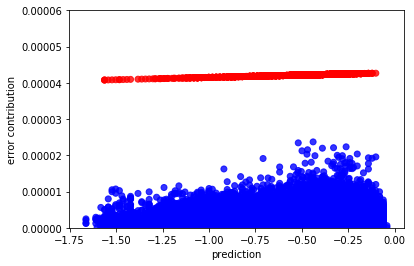

In [43]:
from matplotlib import pyplot as plt
colors = ['blue' if row['err_cntrbtn'] < 0.00003 else 'red' for i, row in data_pred.iterrows()]
plt.scatter(data_pred['predicted'], data_pred['err_cntrbtn'], alpha = 0.8, c = colors)
plt.ylim(0,0.00006)
plt.xlabel('prediction')
plt.ylabel('error contribution')
plt.show()

In [46]:
# Create the new label for Model 0
Model = ['1' if row['err_cntrbtn'] < 0.00003 else '2' for i, row in data_pred.iterrows()]
data_pred['Model'] = Model
data_pred.to_csv('data_labeled')